# NLP pour l’analyse de critiques de films

## Contexte du projet

En règle générale, le nombre d'avis sur un film peu être important et par conséquent le temps de lecture de chaque commentaire peut être une tâche lourde. Alors comment déterminer de manière rapide si un film a eu du succès auprès des spectateurs (ou pas) ? Dans ce contexte, l’idée du projet est d’utiliser des algorithmes d'apprentissage automatique pour la tâche d'analyse de sentiment des spectateurs via leur critique.

Tout d’abord, il sera question que récupérer les données directement du site d’Allociné. En d’autres termes, nous allons scraper les pages qui nous intéressent sur ce site à savoir les critiques des personnes pour le film Inception et Sonic 2.

En navigant sur la page des critiques, vous vous apercevrez que seules deux types d’information ici nous intéresse : la note du spectateur ainsi que son avis. Pourquoi la note ? Parce que nous allons entraîner un modèle de type supervisé et plus précisément un classifieur et donc la note va nous aider à récupérer la classe pour étiqueter le commentaire. Pour cela, nous considérerons qu’une note au-dessus de 3 est considérée comme satisfaisante. Sinon, l’avis est négatif. Ici, nous avons donc réduit le problème à une classification binaire.

## Etape 1 : Web Scraping des données d'avis de spectateurs

Le web scrapping à été réalisé dans le script 'web_scraping.py' et les résultats sont sous forme de dataframes exporté grâce à joblib dans le fichier 'dataframes'



## Etape 2 : Préparation des données

Ayant maintenant nos jeux de données, il faut les préparer afin de pouvoir modéliser notre analyse de sentiments. Pour cela nous allons faire appel à plusieurs techniques :

- Des expressions régulières pour retirer les bruits (ponctuation, etc.) des commentaires.
- Du NLP pour tokeniser et réduire le corpus de chaque commentaire (afin par exemple de ne garder que les mots importants via les stopwords)
  - Des sacs de mots afin de « transformer » nos mots en nombres qui pourront alors être exploités dans un algorithme de Machine learning
  
*Les commentaires seront filtrés à leur essentiel.*

### *Import des librairies :*

In [32]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from unidecode import unidecode
from googletrans import Translator

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer

[nltk_data] Downloading package stopwords to /home/zile/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### *Import des jeux de données :*

In [33]:
df_sonic = joblib.load('dataframes')['sonic2']
df_inception = joblib.load('dataframes')['inception']

df = pd.concat([df_sonic, df_inception])

In [34]:
df.head()

,Commentaires,Notes
0,\nune bonne suite pour les aventures de sonic ...,4.0
1,\nCette suite de sonic est incroyable !Le fan ...,5.0
2,\nTrès bon film ont retrouve ce qui fait l’esp...,4.5
3,"\nSuper film de ouf, le fait que Knuckles soit...",4.0
4,\nMalgré deux nouveaux personnages de l'univer...,3.0


On remarque de suite que les commentaires ne sont pas encore bien mis en forme, il faudra arranger cela par la suite.

On peut aussi directement coder la sortie :

### *Encodage :*

In [35]:
df['Notes'] = df['Notes'].astype('float')
df.loc[df['Notes'] < 3, ['Notes']] = 0
df.loc[df['Notes'] >= 3, ['Notes']] = 1

In [36]:
df['Notes'] = df['Notes'].astype('int')
df['Notes'].value_counts()

1    6237
0    1113
Name: Notes, dtype: int64

On a 6 fois plus de commentaires positifs que de commentaires négatifs, cela peut poser problème et on aura peut-être besoin de faire de la data augmentation

In [37]:
df.isna().sum()

Commentaires    0
Notes           0
dtype: int64

Aucune valeur nulle.

In [38]:
df.shape

(7350, 2)

On a un total de 7350 commentaires dans notre dataset

### *Gestion du bruit des commentaires :*

On définit une fonction pour supprimer le bruit :
- Suppresion des caractères spéciaux
- Désaccentuation
- Tout passer en minuscule

In [39]:
def standardize_text(df, content_field):
    df[content_field] = df[content_field].str.replace(r"http\S+", "", regex=True)
    df[content_field] = df[content_field].str.replace(r"http", "", regex=True)
    df[content_field] = df[content_field].str.replace(r"@\S+", "", regex=True)
    df[content_field] = df[content_field].str.replace(r"[0-9(),!?@\'\:\.\/\^\-\`\"\_\n]", " ", regex=True)
    df[content_field] = df[content_field].str.replace(r"@", "at", regex=True)
    df[content_field] = df[content_field].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
    df[content_field] = df[content_field].str.lower()
    return df

In [40]:
standardize_text(df, 'Commentaires')
df.head()

,Commentaires,Notes
0,une bonne suite pour les aventures de sonic a...,1
1,cette suite de sonic est incroyable le fan q...,1
2,tres bon film ont retrouve ce qui fait lespri...,1
3,super film de ouf le fait que knuckles soit ...,1
4,malgre deux nouveaux personnages de l univers...,1


### *Séparation du jeu de données :*

Les prochaines étapes de préparation ne doivent s'appliquer qu'au jeu d'entraînement, il nous faut garder un jeu de test intact.

In [41]:
y = df['Notes']
X = df['Commentaires']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Notre jeu d'entrainement contient {X_train.shape[0]} commentaires et celui de test en contient {X_test.shape[0]}")

Notre jeu d'entrainement contient 5880 commentaires et celui de test en contient 1470


### *Tokenisation :*

Le but désormais est de constituer notre *corpus* (collection de commentaires) traité, c'est à dire sans *'stop words'* et *lemmatisé*.

- Les *'stop words'* sont les mots qui n'apportent aucune information.

- La *lematisation* consiste à réduire un mot à sa forme de base (ex : mangea devient manger). 

On utilisera la librarie `FrenchLefffLemmatizer` developpée par Claude Colombe

In [42]:
print(f"Voici la liste des stopwords de la langue française : \n {stopwords.words('french')}")

Voici la liste des stopwords de la langue française : 
 ['au', 'aux', 'avec', 'ce', 'ces', 'dans', 'de', 'des', 'du', 'elle', 'en', 'et', 'eux', 'il', 'ils', 'je', 'la', 'le', 'les', 'leur', 'lui', 'ma', 'mais', 'me', 'même', 'mes', 'moi', 'mon', 'ne', 'nos', 'notre', 'nous', 'on', 'ou', 'par', 'pas', 'pour', 'qu', 'que', 'qui', 'sa', 'se', 'ses', 'son', 'sur', 'ta', 'te', 'tes', 'toi', 'ton', 'tu', 'un', 'une', 'vos', 'votre', 'vous', 'c', 'd', 'j', 'l', 'à', 'm', 'n', 's', 't', 'y', 'été', 'étée', 'étées', 'étés', 'étant', 'étante', 'étants', 'étantes', 'suis', 'es', 'est', 'sommes', 'êtes', 'sont', 'serai', 'seras', 'sera', 'serons', 'serez', 'seront', 'serais', 'serait', 'serions', 'seriez', 'seraient', 'étais', 'était', 'étions', 'étiez', 'étaient', 'fus', 'fut', 'fûmes', 'fûtes', 'furent', 'sois', 'soit', 'soyons', 'soyez', 'soient', 'fusse', 'fusses', 'fût', 'fussions', 'fussiez', 'fussent', 'ayant', 'ayante', 'ayantes', 'ayants', 'eu', 'eue', 'eues', 'eus', 'ai', 'as', 'avons',

On définit note fonction créer notre corpus :

In [43]:
def make_corpus(df):
    lemmatizer = FrenchLefffLemmatizer()
    corpus = []
    for message in df:
        message = message.split()                                   
        message =[word for word in message if not word in set(stopwords.words('french'))]
        message = [lemmatizer.lemmatize(word) for word in message]
        message = ' '.join(message)
        corpus.append(message)
    return corpus

In [44]:
corpus = make_corpus(X_train) #Temps d'éxecution : ~30-45s

In [45]:
print(f"Quelques exemple de commentaires filtrés à l'essentiel : \n\n{corpus[456]}\n\n{corpus[1456]}\n\n{corpus[25]}\n\n{corpus[3569]}")

Quelques exemple de commentaires filtrés à l'essentiel : 

christopher nolan signe encore excellent film effet speciaux enormes bande aussi acteur parfaitement bien choisis pris dedans debut a fin minute ennuie merveilleux

thriller film action a tres haut niveau grand nolan scenario assez original faire film film complet excellent voit plus acteur jouer leurs personnage seul bemol quelques longueur idee tres develloppee quelques scenes rappelle shutter island scorcese aussi leonardo dicaprio etait aussi tres bon film allez voir regretterez

enorme scenario effet speciaux a voir absolument contre tentez distraire autre chose film pendant projection sou peine etre largue intrigue a sortie seance quel plaisir quelles impression beau cinema

rien compris desole vraiment rien si quelqu veut bien expliquer


Les commentaires sont donc maintenant bien traités, on peut passer à la prochaine étape.


## Etape 3 : Finalisation de nos jeux de données

Les données sont presque prêtes mais nos commentaires qui sont maintenant sous forme de sac de mots doivent être convertis en nombre. Pour cela, il va falloir vectoriser nos mots (technique des sacs de mots)

### *Vectorisation :*

In [46]:
tfidf = TfidfVectorizer()
X_train_vec = tfidf.fit_transform(corpus)

### *WordClouds :*

Les nuages de mots sont un bon moyen de visualiser quels mots présents le plus fréquemment dans un document.

Ici, on va essayer d'en afficher deux :
- Un pour les avis négatifs
- Un pour les avis positifs

On commence par récupérer tout les mots des commentaires négatifs et positifs :

In [47]:
text_negatif = ''
neg = df[df['Notes'] == 0]
for item in neg['Commentaires'].items():
    text_negatif = text_negatif + item[1]

text_positif = ''
pos = df[df['Notes'] == 1]
for item in pos['Commentaires'].items():
    text_positif = text_positif + item[1]

Ensuite, on va décider de ne pas afficher dans nos WordCloud les mots en communs entre les avis négatifs et positifs et les stopwords qui n'apportent aucune information.

In [48]:
set1 = set(text_positif.split())
set2 = set(text_negatif.split())

# Création de la liste de mots en commun
words_film_related = list(set1.intersection(set2))

stopwords_cloud = stopwords.words('french') + words_film_related

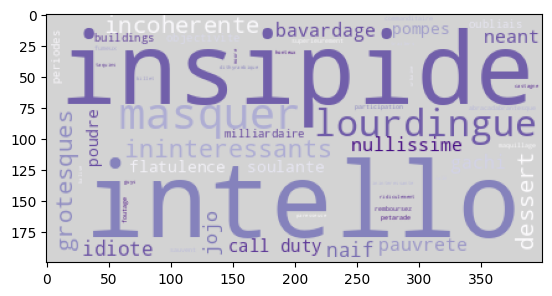

In [52]:
wordcloud_neg = WordCloud(background_color='#D3D3D3', colormap='Purples', max_words=50, min_word_length=3, stopwords=stopwords_cloud).generate(text_negatif)
plt.imshow(wordcloud_neg)

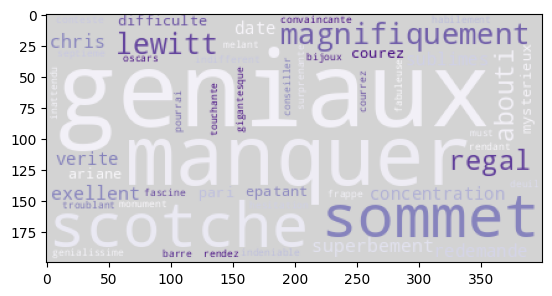

In [54]:
wordcloud_pos = WordCloud(background_color='#D3D3D3', colormap='Purples', max_words=50, min_word_length=3, stopwords=stopwords_cloud).generate(text_positif)
plt.imshow(wordcloud_pos)

## Etape 4 : Entraînement du modèle

Nos données sont prêtes, nous allons pour ce premier exercice utiliser un algorithme de Regression Logistique comme ici il est question de classification binaire. Entraînons le modèle maintenant, et regardons sa précision par rapport au libellés connus.

In [94]:
clf = LogisticRegression(random_state=42)
clf.fit(X_train_vec, y_train)

LogisticRegression(random_state=42)

## Etape 5 : Analyse des résultats

Calculer l’accuracy et la matrice de confusion sur les données de test. Une fois que les résultats sont satisfaisants, vous pourrez maintenant tester sur des commentaires que vous et vos collègues ferons afin de vérifier le bon fonctionnement du programme.

In [95]:
corpus_test = make_corpus(X_test)
X_test_vec = tfidf.transform(corpus_test)

Accuracy of LogisticRegression: 90.40816326530611 %


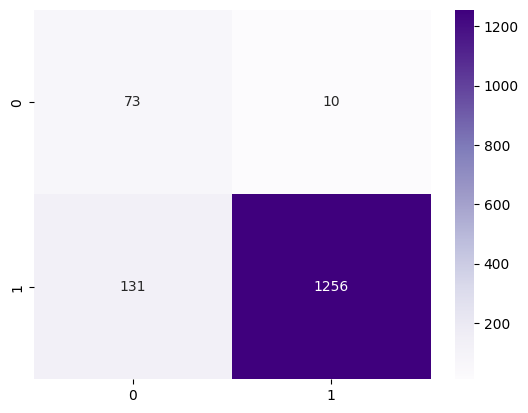

In [96]:
y_pred_clf = clf.predict(X_test_vec)
acc_clf = accuracy_score(y_pred_clf, y_test)
cm_clf = confusion_matrix(y_pred_clf, y_test)
sns.heatmap(cm_clf, annot=True, cmap='Purples', fmt='g')
print(f"Accuracy of {clf.__class__.__name__}:", acc_clf*100,"%")

Le score est bon mais grâce à la matrice de confusion on voit tout de suite que le modèle n'arrive pas à reconnaitre des avis négatifs. En effet, ce dernier à été entrainé sur une majorité d'avis positifs.

Effectuons quelques vérifications et donnant un commentaire négatif et analysons sa prédiction.

In [97]:
bad_comment = "Très déçu de ce film, je n'ai pas du tout aimé"

def standardize_lemmentize_vectorize(comment: str, lemmatizer, vectorizer):

    comment = comment.replace(r"http\S+", "")
    comment = comment.replace(r"http", "")
    comment = comment.replace(r"@\S+", "")
    comment = comment.replace(r"[0-9(),!?@\'\:\.\/\^\-\`\"\_\n]", " ")
    comment = comment.replace(r"@", "at")
    comment = unidecode(comment)
    comment = comment.lower()
    comment = comment.split()
    comment = [word for word in comment if not word in set(stopwords.words('french'))]
    comment = [lemmatizer.lemmatize(word) for word in comment]
    comment = ' '.join(comment)
    comment = vectorizer.transform([comment])
    return comment

bad_comment = standardize_lemmentize_vectorize(bad_comment, FrenchLefffLemmatizer(), tfidf)

In [98]:
pred = clf.predict(bad_comment)
pred

array([1])

Comme prévu le modèle est entrainé avec trop d'avis positif et n'arrive pas à reconnaitre un avis négatif. 

On se doit de faire de la data augmentation sur notre jeu d'entrainement pour équilibrer les classes.

## Etape 6 : Data Augmentation

In [99]:
print(f"""Dans la première version du trainset nous avions {X_train[y_train == 0].shape[0]} avis négatifs pour {X_train[y_train == 1].shape[0]} avis positifs""")

Dans la première version du trainset nous avions 909 avis négatifs pour 4971 avis positifs


L'idée ici est de multiplier par au moins 4 le nombre d'avis négatifs pour avoir un bon équilibrage par la suite.

Dans un premier temps des tests ont été effectués avec la librairie nlpaug (word embedding) mais les temps de calculs étaient horriblement longs (plus de 10mn pour transformer une phrase) donc cette solution à été abandonnée.

On va essayer la solution du back translate, i.e traduire les commentaires en anglais puis les re traduire en français pour obtenir des commentaires avec la même signification mais écrits différements.

In [101]:
def back_translate(sequence):
    """Traduit une séquence en anglais puis de nouveau en français et
    renvoie l'output"""
    #instantiate translator
    translator = Translator()
    #translate to new language
    translated = translator.translate(sequence, dest = 'en').text
    #translate back to original language
    translated_back = translator.translate(translated, dest = 'fr').text
    
    return translated_back

In [102]:
# Temps d'éxecution : 3mn30s
# for i in X_train[y_train == 0]:
#     output = back_translate(i)
#     X_train = pd.concat([X_train, pd.Series(output)])
#     y_train = pd.concat([y_train, pd.Series(0)])

In [103]:
print(f"""Dans la deuxième version du trainset nous avons {X_train[y_train == 0].shape[0]} avis négatifs pour {X_train[y_train == 1].shape[0]} avis positifs""")

Dans la deuxième version du trainset nous avons 1818 avis négatifs pour 4971 avis positifs


Deux options s'offrent à nous : soit supprimer des avis positifs ou ajouter une nouvelle fois des avis négatifs. 

La deuxième option semble la mieux pour éviter de perdre de l'information.

In [104]:
# Temps d'éxecution : 12mn30s
# for i in X_train[y_train == 0]:
#     output = back_translate(i)
#     X_train = pd.concat([X_train, pd.Series(output)])
#     y_train = pd.concat([y_train, pd.Series(0)])

In [105]:
print(f"""Dans la troisème version du trainset nous avons {X_train[y_train == 0].shape[0]} avis négatifs pour {X_train[y_train == 1].shape[0]} avis positifs""")

Dans la troisème version du trainset nous avons 3636 avis négatifs pour 4971 avis positifs


L'équilibre est plutôt bon, essayons d'entrainer notre modèle sur ce trainset et comparons avec nos résultats précédents.

Avant toute chose on va sauvegarder ce trainset pour éviter de relancer le code qui s'éxecute en 20mn.

### *Sauvegarde du trainset :*

In [106]:
# joblib.dump(X_train, 'X_train_aug_v1')
# joblib.dump(y_train, 'y_train_aug_v1')

['y_train_aug_v1']

In [107]:
X_train_aug = joblib.load('X_train_aug_v1')
y_train_aug = joblib.load('y_train_aug_v1')

### *Machine learning :*

In [108]:
corpus_train_aug = make_corpus(X_train_aug)

tfidf_v2 = TfidfVectorizer()

X_train_aug_vec = tfidf_v2.fit_transform(corpus_train_aug)
X_test_vec = tfidf_v2.transform(corpus_test)

In [109]:
clf_v2 = LogisticRegression(random_state=42)
clf_v2.fit(X_train_aug_vec, y_train_aug)

LogisticRegression(random_state=42)

Accuracy of LogisticRegression: 90.61224489795919 %


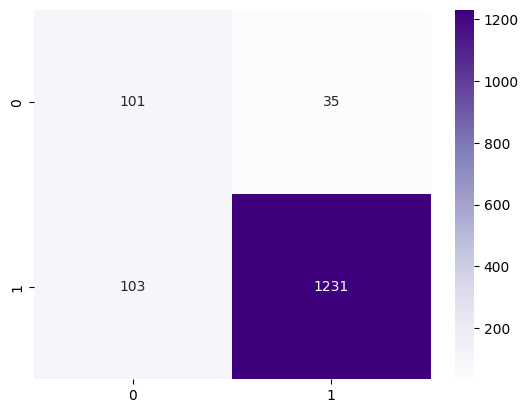

In [110]:
y_pred_clf_v2 = clf_v2.predict(X_test_vec)
acc_clf_v2 = accuracy_score(y_pred_clf_v2, y_test)
cm_clf_v2 = confusion_matrix(y_pred_clf_v2, y_test)
sns.heatmap(cm_clf_v2, annot=True, cmap='Purples', fmt='g')
print(f"Accuracy of {clf_v2.__class__.__name__}:", acc_clf_v2*100,"%")

Le modèle se trompe une fois sur deux pour les avis négatifs. Toutefois, le résultats ne sont pas beacoup mieux.

Cela vient surement du fait que la data augmentation via traduction a du ajouter beaucoup de nouveaux commentaires en doublons.

In [111]:
bad_comment_v2 = "Très déçu de ce film, je n'ai pas du tout aimé"
print(bad_comment_v2)

bad_comment_v2 = standardize_lemmentize_vectorize(bad_comment_v2, FrenchLefffLemmatizer(), tfidf_v2)
pred = clf_v2.predict(bad_comment_v2)
pred

Très déçu de ce film, je n'ai pas du tout aimé


array([0])

Cette fois ci, le modèle a réalisé la bonne prédiction. On peut s'en contenter pour la suite.

### *Sauvegarde des éléments nécessaires à l'application :*

In [112]:
datas = {
    'modele' : clf_v2,
    'lemmatiser' : FrenchLefffLemmatizer(),
    'vectoriser' : tfidf_v2,
}

joblib.dump(datas, 'for_app')

['for_app']

## Etape 7 : Réalisation d'une application WEB avec Flask qui lit un commentaire de Film et détermine s'il est positif ou pas

L'application est contenue dans le fichier `Flask_app`, il suffit d'executer le script python nommé 'app.py'.